In [1]:
import gym
import matplotlib.pyplot as plt
import collections
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

from tensorflow import keras
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.python.client import device_lib
from random import sample

from hyperopt import fmin, tpe, hp, Trials, space_eval, STATUS_OK
import pickle

import pandas as pd
from openpyxl import load_workbook

print(tf.__version__)
print(device_lib.list_local_devices())

c:\Users\Go\miniconda3\envs\tensorgpu\lib\site-packages\flatbuffers\compat.py:19: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp
c:\Users\Go\miniconda3\envs\tensorgpu\lib\site-packages\keras_preprocessing\image\utils.py:23: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  'nearest': pil_image.NEAREST,
c:\Users\Go\miniconda3\envs\tensorgpu\lib\site-packages\keras_preprocessing\image\utils.py:24: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  'bilinear': pil_image.BILINEAR,
c:\Users\Go\miniconda3\envs\tensorgpu\lib\site-packages\keras_preprocessing\image\utils.py:25: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  'bicubic': pil_image.BICUBIC,
c:\Users\Go\minic

2.8.0
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6949286596552294004
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3667263488
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10787605495105316448
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


In [6]:
def make_dense_model(hidden_structure,input_shape,act_function,output_shape):
    inputs = tf.keras.Input(shape=input_shape)
    
    for i, val in enumerate(hidden_structure):
        n_percep = val 
        if i == 0:
            # x = keras.layers.Dense(n_percep, activation= act_function)(inputs)
            x = keras.layers.Dense(n_percep,)(inputs)

        elif  i != 0 and i != len(hidden_structure)-1:
            x = keras.layers.Dense(n_percep,)(x)

        elif  i == len(hidden_structure)-1:
            x = keras.layers.Dense(n_percep,)(x)
            # x = keras.layers.Dense(n_percep)(x)
    x = keras.layers.Dense(output_shape)(x)

    dense_model = tf.keras.Model(inputs=inputs, outputs=x)
    return dense_model

def get_batchdata(replay_buffer, n_batch):
    batched_dataset = np.array(sample(replay_buffer, n_batch))

    s_batch = tf.reshape(batched_dataset[:,0].tolist(),[-1,4])
    a_batch = tf.reshape(batched_dataset[:,1].astype(np.int32),[-1,1])
    ns_batch = tf.reshape(batched_dataset[:,2].tolist(),[-1,4])
    r_batch = tf.reshape(batched_dataset[:,3].astype(np.float32),[-1,1])
    done_batch = tf.reshape(batched_dataset[:,4].astype(np.float32),[-1,1])

    return s_batch,a_batch,ns_batch,r_batch,done_batch,

def get_action(environment, model, state, eps):
    if np.random.random() <= eps:
        return environment.action_space.sample()
    else:
        qs = model(tf.convert_to_tensor([state], dtype=tf.float32))
        return np.argmax(qs.numpy())

def play_random_action_episodes(environment, replay_buffer, n_random_episode):
    for _ in range(n_random_episode):
        s = environment.reset()
        a = environment.action_space.sample()
        while True:
            ns, r, done, _ = environment.step(a)
            done = 1 if done else 0
            replay_buffer.append((tf.convert_to_tensor(s),a,tf.convert_to_tensor(ns),r, done))

            if done == 1:
                s = environment.reset()
                a = environment.action_space.sample()
                break
            else:
                s = ns
                a = environment.action_space.sample()


    

def update_target_network(q_network, q_network_target, TAU):
    phi = q_network.get_weights()
    target_phi = q_network_target.get_weights()
    for i in range(len(phi)):
        target_phi[i] = TAU * phi[i] + (1 - TAU) * target_phi[i]
    q_network_target.set_weights(target_phi)

def update_q_net(optimizer,q_network, q_network_target, rep_buffer, n_batch, tau):
    with tf.GradientTape(watch_accessed_variables=True) as tape:
        state, action, nstate, reward, done = get_batchdata(rep_buffer,n_batch)
        q_val = tf.reshape(tf.gather_nd(params = q_network(state),indices=action, batch_dims=1), [-1,1])
        max_q = tf.reshape(tf.reduce_max(q_network_target(nstate),axis=1),[-1,1])
        y = reward + GAMMA*max_q*(1-done)

        loss = tf.reduce_mean(tf.square(q_val-y))
    grads = tape.gradient(loss, q_network.trainable_variables)
    optimizer.apply_gradients(zip(grads, q_network.trainable_variables))

    update_target_network(q_network, q_network_target, tau)
    return loss.numpy()
    

    

GAMMA = 0.95
BATCH_SIZE = 256
BUFFER_SIZE = 200000
DQN_LEARNING_RATE = 0.001
TAU = 0.0001
EPSILON = 1.0
EPSILON_DECAY = 0.995
EPSILON_MIN = 0.01
MAX_EPISODE_NUM = 10000
eval_per_iter = 20
eval_iter_n = 1
random_epi_num = 5000

env = gym.make('CartPole-v1')
hidden_structure= [64, 128,256,128,64]
input_shape= 4
output_shape= 2
act_function= 'relu'
optimizer = keras.optimizers.Adam(learning_rate=DQN_LEARNING_RATE)

q_net = make_dense_model(hidden_structure,input_shape,act_function,output_shape)
q_net_tar = make_dense_model(hidden_structure,input_shape,act_function,output_shape)
# loss = tf.reduce_mean(tf.square(q_values-td_targets))
replay_buffer = []
mean_reward = []
cum_reward_hist = []
loss_hist = []
eps_hist = []

In [7]:
### train dqn ###
play_random_action_episodes(env, replay_buffer, random_epi_num)
for i in range(MAX_EPISODE_NUM):
    s = env.reset()
    a = get_action(env, q_net, s, EPSILON)
    cur = 0
    while True:
        # decaying EPSILON
        if EPSILON > EPSILON_MIN:
            EPSILON *= EPSILON_DECAY
            eps_hist.append(EPSILON)
        ns, r, done, _ = env.step(a)
        cur += r
        done = 1 if done else 0

        if len(replay_buffer) < BUFFER_SIZE:
            replay_buffer.append((tf.convert_to_tensor(s),a,tf.convert_to_tensor(ns),r, done))
        else:
            replay_buffer.append((tf.convert_to_tensor(s),a,tf.convert_to_tensor(ns),r, done))
            replay_buffer = replay_buffer[1:]

        if done == 1:
            s = env.reset()
            a = get_action(env, q_net, s, EPSILON)
            break
        else:
            s = ns
            a = get_action(env, q_net, s, EPSILON)
        
        if len(replay_buffer)>BATCH_SIZE:
            # optimizer,q_network, q_network_target, rep_buffer, n_batch, tau
            loss = update_q_net(optimizer, q_net, q_net_tar,replay_buffer,BATCH_SIZE,TAU)
            loss_hist.append(loss)
    cum_reward_hist.append(cur)
    ## xx번 에피소드마다 평가 ##
    if i%eval_per_iter == 0:
        cumr = []
        for _ in range(eval_iter_n):
            
            t_r = 0
            s = env.reset()
            env.render()
            a = get_action(env, q_net, s, EPSILON)


            while True:
                # decaying EPSILON
                if EPSILON > EPSILON_MIN:
                    EPSILON *= EPSILON_DECAY
                ns, r, done, _ = env.step(a)
                env.render()
                t_r += r
                done = 1 if done else 0

                if len(replay_buffer) < BUFFER_SIZE:
                    replay_buffer.append((tf.convert_to_tensor(s),a,tf.convert_to_tensor(ns),r, done))
                else:
                    replay_buffer.append((tf.convert_to_tensor(s),a,tf.convert_to_tensor(ns),r, done))
                    replay_buffer = replay_buffer[1:]

                if done == 1:
                    s = env.reset()
                    env.render()
                    a = get_action(env, q_net, s, EPSILON)
                    cumr.append(t_r)
                    break
                else:
                    s = ns
                    a = get_action(env, q_net, s, EPSILON)
        mean_reward.append(sum(cumr)/eval_iter_n)
        print(f"평균보상: {sum(cumr)/eval_iter_n}, iteratioin: {i}")

C:\Users\Go\AppData\Local\Temp\ipykernel_14140\1883901274.py:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  batched_dataset = np.array(sample(replay_buffer, n_batch))


평균보상: 14.0, iteratioin: 0
평균보상: 10.0, iteratioin: 20
평균보상: 9.0, iteratioin: 40
평균보상: 9.0, iteratioin: 60
평균보상: 26.0, iteratioin: 80
평균보상: 9.0, iteratioin: 100
평균보상: 19.0, iteratioin: 120
평균보상: 10.0, iteratioin: 140
평균보상: 9.0, iteratioin: 160
평균보상: 10.0, iteratioin: 180
평균보상: 10.0, iteratioin: 200
평균보상: 10.0, iteratioin: 220
평균보상: 9.0, iteratioin: 240
평균보상: 9.0, iteratioin: 260
평균보상: 9.0, iteratioin: 280
평균보상: 10.0, iteratioin: 300
평균보상: 9.0, iteratioin: 320
평균보상: 11.0, iteratioin: 340
평균보상: 9.0, iteratioin: 360
평균보상: 9.0, iteratioin: 380
평균보상: 9.0, iteratioin: 400
평균보상: 9.0, iteratioin: 420
평균보상: 10.0, iteratioin: 440
평균보상: 10.0, iteratioin: 460
평균보상: 9.0, iteratioin: 480
평균보상: 9.0, iteratioin: 500
평균보상: 10.0, iteratioin: 520
평균보상: 10.0, iteratioin: 540
평균보상: 9.0, iteratioin: 560
평균보상: 9.0, iteratioin: 580
평균보상: 9.0, iteratioin: 600
평균보상: 9.0, iteratioin: 620
평균보상: 9.0, iteratioin: 640
평균보상: 9.0, iteratioin: 660
평균보상: 10.0, iteratioin: 680
평균보상: 10.0, iteratioin: 700
평균보상: 10.0, iterat

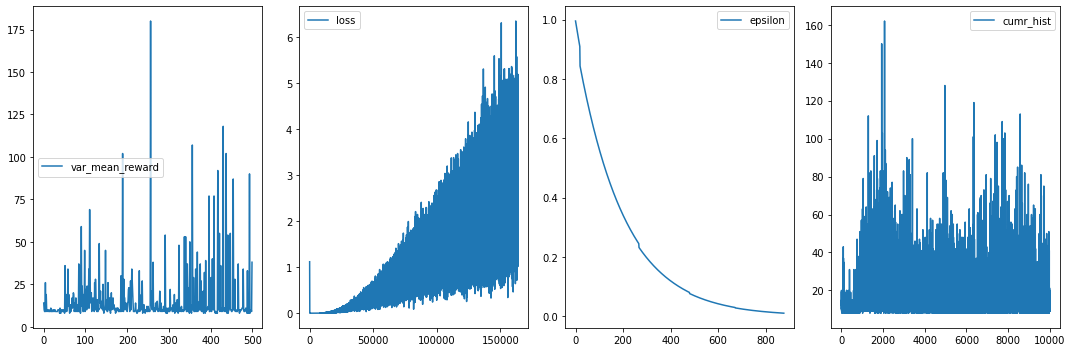

In [9]:
fig, axes = plt.subplots(1,4, figsize=(15,5))
axes[0].plot(mean_reward, label='var_mean_reward')
axes[0].legend()

axes[1].plot(loss_hist, label='loss')
axes[1].legend()
fig.tight_layout()
# cum_reward_hist
axes[2].plot(eps_hist, label='epsilon')
axes[2].legend()

axes[3].plot(cum_reward_hist, label='cumr_hist')
axes[3].legend()
fig.tight_layout()

In [211]:
EPSILON

0.00998645168764533

In [ ]:
tf.reduce_mean(tf.square(q_val-y))

In [201]:

state, action, nstate, reward, done = get_batchdata(replay_buffer,32)
q_val = tf.reshape(tf.gather_nd(params = q_net(state),indices=action, batch_dims=1), [-1,1])
max_q = tf.reshape(tf.reduce_max(q_net_tar(nstate),axis=1),[-1,1])
y = reward + GAMMA*max_q*(1-done)

loss = tf.reduce_mean(tf.square(q_val-y))

C:\Users\Go\AppData\Local\Temp\ipykernel_25848\1099583015.py:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  batched_dataset = np.array(sample(replay_buffer, n_batch))


In [203]:
loss.numpy()

1.1580547

In [192]:

s = env.reset()
env.render()
a = get_action(env, q_net, s, EPSILON)


while True:
    ns, r, done, _ = env.step(a)
    env.render()
    if done == 1:
        break
    else:
        s = ns
        a = get_action(env, q_net, s, EPSILON)
    